# Hybrid CART

# Imports

In [44]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator
from utils.classifierGenerator import ClassifierGenerator


import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Load hybrids cars

In [45]:
data = Loader.load_by_fueltype("Híbrido")
label_encoder = LabelEncoder()

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

In [46]:
data["price_categ"].value_counts()

price_categ
Middle low range     6780
Middle range         3700
Middle high range    2364
Premiun              2137
Luxury               1829
High end             1766
Budget               1367
Low end               147
Very low end            9
Name: count, dtype: int64

This result is telling us that in the world of hybrid cars is much common to have a high price car than a low end hybrid car. So as we can see that our dataset is not perfectly balanced so we are going to studie and transform this data to make it more tratable for the clasificattion algorithms

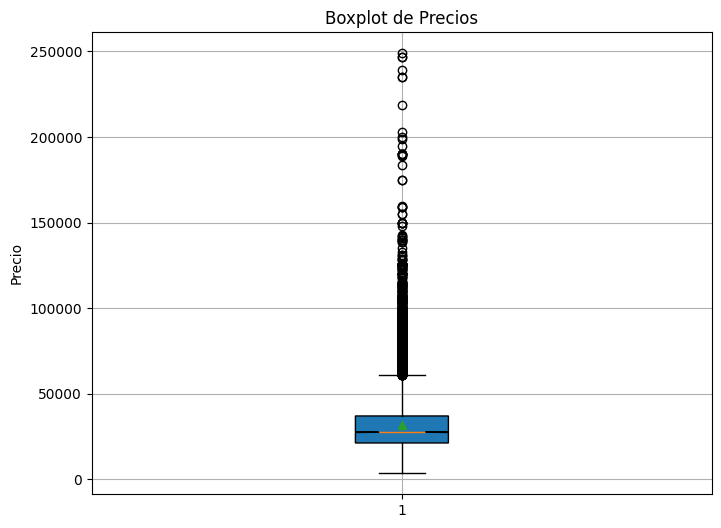

In [47]:
precios_hibridos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_hibridos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [48]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Híbrido"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

60663.75


,price,brand
idx,,
1412,248900,LAND-ROVER
129813,246743,LAND-ROVER
130244,246743,LAND-ROVER
12846,239000,LAND-ROVER
53326,234900,LAND-ROVER
...,...,...
49406,60900,AUDI
22550,60900,AUDI
40577,60900,MERCEDES-BENZ


# PCA and correlation matrix

In [49]:
def fill_hybrid_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_hybrid_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_hybrid_numerical_columns(numerical_columns)


In [50]:
numerical_columns = get_hybrid_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.1921738848689007%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 13.021414929074654%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 7.807865383114092%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.150602004390281%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.842150243715259%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 20.647155838330754%


In [51]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.159676
year                     0.314151
cubicCapacity            0.577080
doors                    0.041913
seatingCapacity          0.234695
trunkCapacityInLiters    0.431428
maxSpeed                 0.580215
acceleration            -0.605923
power_cv                 0.756233
power_kw                 0.756358
max_torque_nm            0.762390
speakers                 0.369709
dimensions.width         0.645872
dimensions.height        0.344293
dimensions.length        0.606820
Numero_Testigos          0.097956
displacement_liters      0.575881
displacement_cc         -0.318374
number_of_cylinders      0.562774
compression_ratio       -0.249466
Llantas_Diametro_cm      0.627018
Name: price, dtype: float64


In [52]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

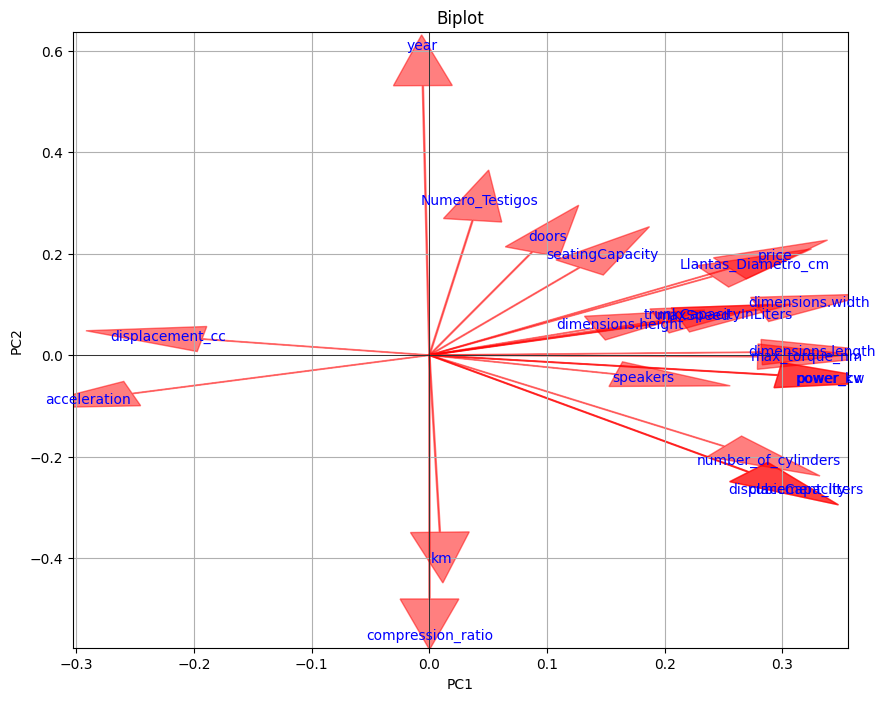

In [53]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

### Test Tree regressor

In [54]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 1931.877434566051 
 MSE: 13832395.289788494 
 RMSE: 3719.192827723308 
 R2: 0.9540946652424339 
 MAPE: 5.958070059651133
Mean: 1931.877434566051
Variance: 10100244.867602987
Standard Deviation: 3178.0882410032273


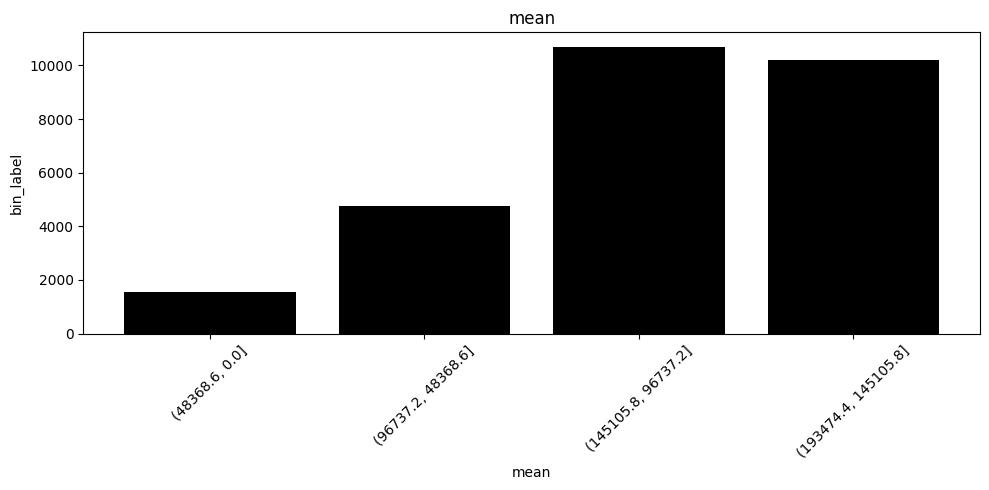

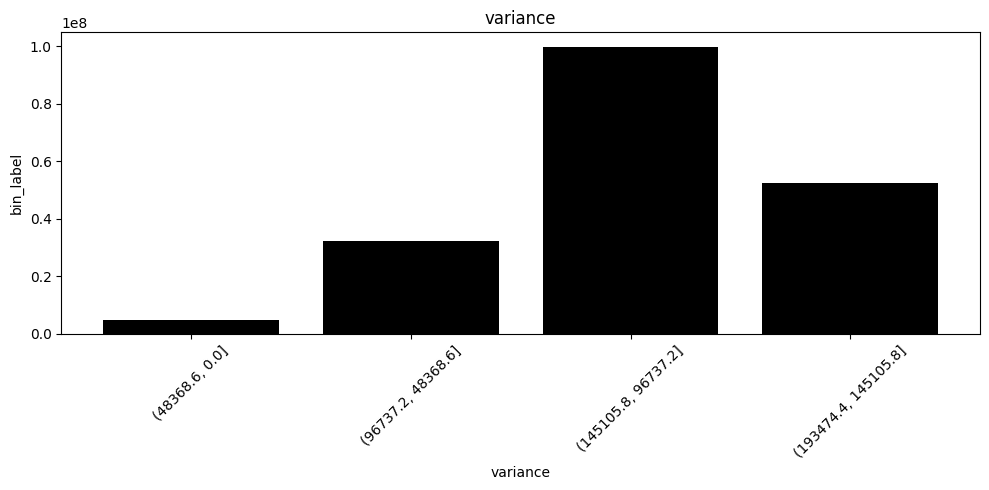

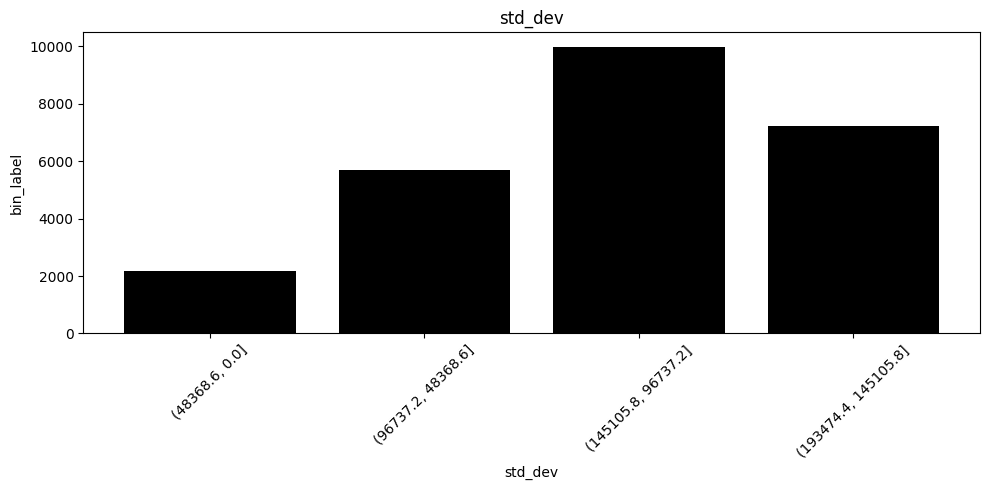

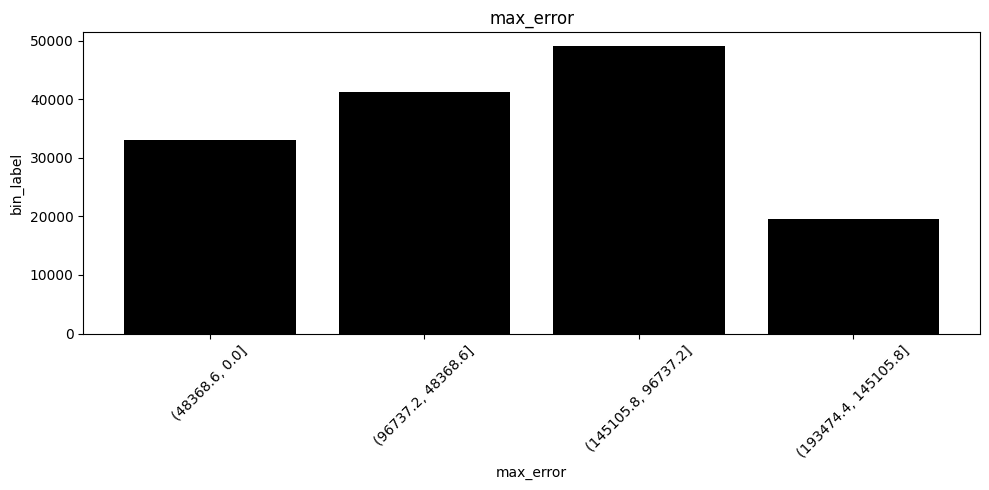

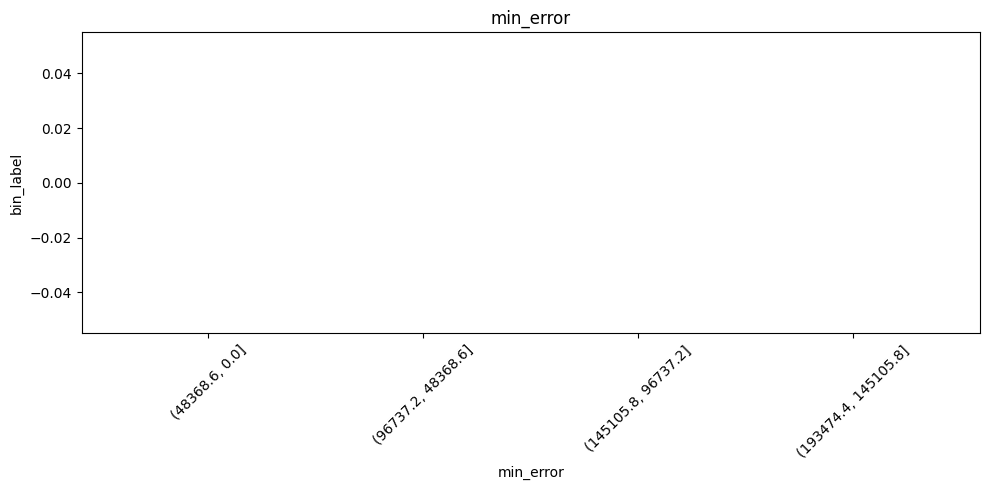

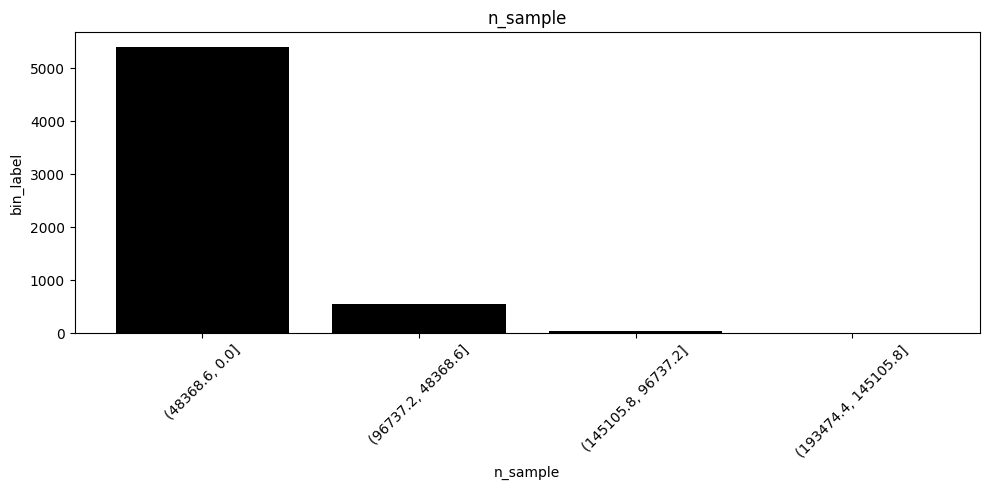

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(48368.6, 0.0]",1534.095229,4.716822e+06,2171.824522,33000.0,0.0,5404
1,"(96737.2, 48368.6]",4750.441936,3.238649e+07,5690.912653,41200.0,0.0,563
2,"(145105.8, 96737.2]",10696.567308,9.985554e+07,9992.774599,49000.0,0.0,52
3,"(193474.4, 145105.8]",10207.142857,5.233888e+07,7234.561324,19600.0,0.0,7


In [55]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

In [56]:
def get_hybrid_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    data['price_categ'] = data['price_categ'].astype('category')

    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_hybrid_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df

# convert object columns to category
data = category_convert(data)

categorical_columns = get_hybrid_categorical_columns(data)

categorical_columns = fill_hybrid_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#print("Columnas en categorical_columns:", categorical_columns.columns)


Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 0
Number of missing values in 'environmentalLabel' before filling with 'unknown': 1
Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [57]:

# Obtener la distribución con los nombres de categoría
distribution = categorical_columns["price_categ"].value_counts()
print(distribution)


price_categ
Middle low range     6780
Middle range         3700
Middle high range    2364
Premiun              2137
Luxury               1829
High end             1766
Budget               1367
Low end               147
Very low end            9
Name: count, dtype: int64


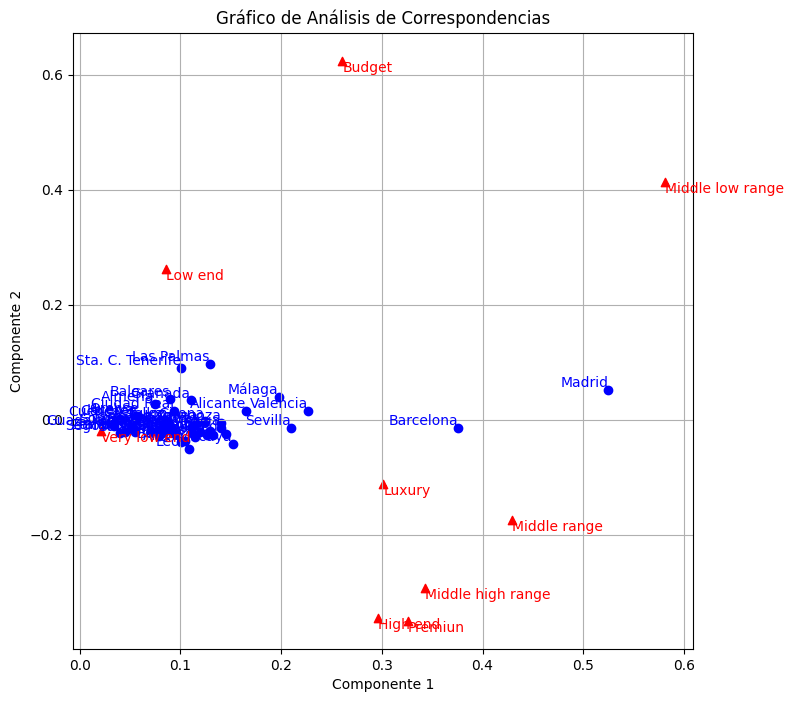

In [58]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

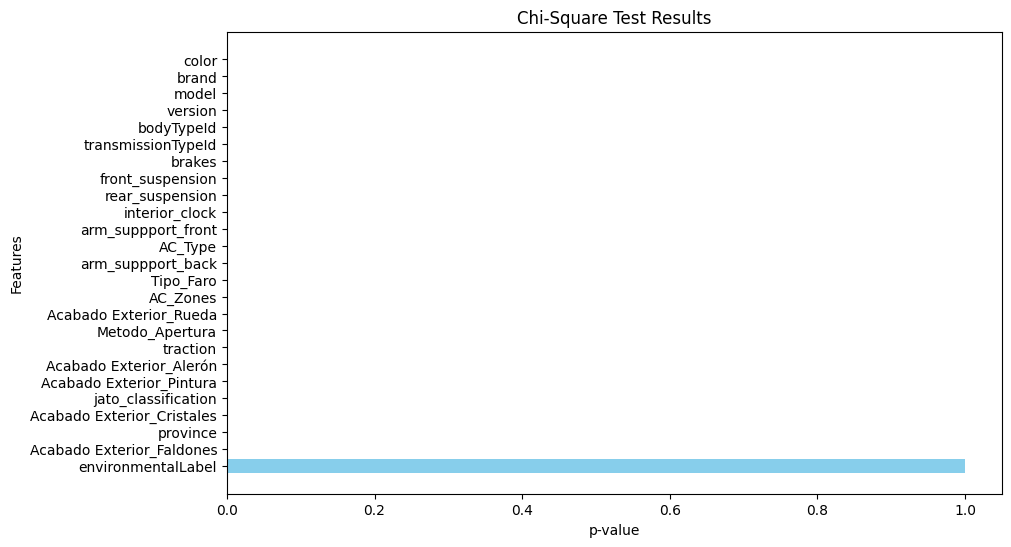

,Feature,Chi2 Stat,p-value
0,color,6.904929e+04,0.000000e+00
1,brand,6.670518e+03,0.000000e+00
2,model,4.519651e+04,0.000000e+00
3,version,1.244725e+06,0.000000e+00
4,bodyTypeId,9.020079e+03,0.000000e+00
5,transmissionTypeId,3.210345e+03,0.000000e+00
10,brakes,5.274799e+03,0.000000e+00
11,front_suspension,2.101354e+03,0.000000e+00
12,rear_suspension,7.840275e+03,0.000000e+00
22,interior_clock,1.627225e+03,0.000000e+00


In [59]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

# Categorical CART

In [60]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)


In [61]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
151243,Premiun,Premiun,0
27724,Middle range,Middle range,0
95582,Premiun,Premiun,0
22666,Budget,Middle low range,1
73600,Budget,Budget,0
...,...,...,...
102354,Premiun,High end,1
132055,Middle high range,Middle high range,0
102253,Middle range,Middle range,0


In [62]:
# Calcular la precisión
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7466003316749585 
 Precision: 0.7457166972090772 
 Recall: 0.7466003316749585 
 F1 Score: 0.745999442393832
Confusion Matrix:
 [[1729    6    3    1   26   75  178    1    2]
 [  10  328    2   10   89    0   25   78    0]
 [   7    0   21    1    0   16    1    0    1]
 [   0   10    0  442    5    0    3   78    0]
 [  36   85    2    2  447    1  136   19    0]
 [  90    0   13    0    0  301    2    0    0]
 [ 194   16    0    1  105    3  761    7    0]
 [   2   84    0   64   22    1   14  473    0]
 [   0    0    0    0    0    1    0    0    0]]


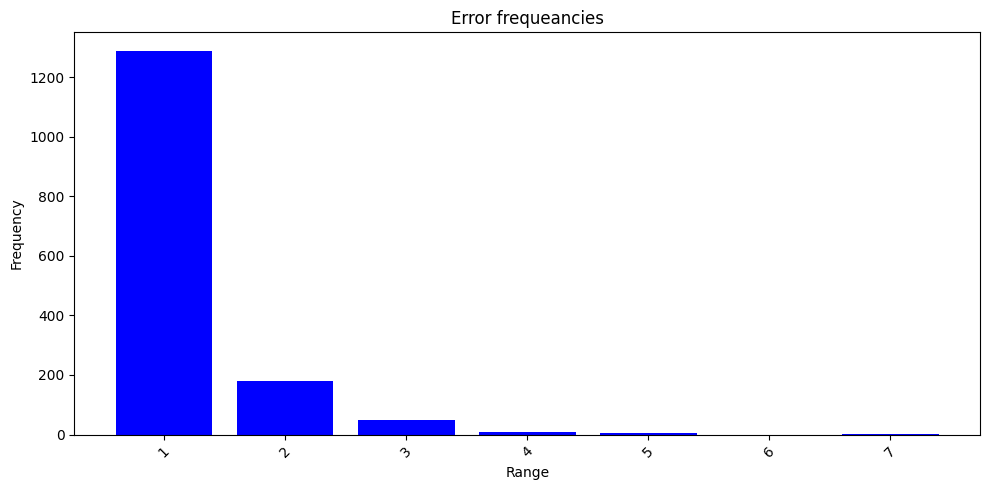

{np.int64(1): np.int64(1286), np.int64(2): np.int64(180), np.int64(3): np.int64(48), np.int64(4): np.int64(9), np.int64(5): np.int64(4), np.int64(7): np.int64(1)}
Error mean: 1.212696335078534
Error rate: 25.339966832504146 %
Overall mean: 0.30729684908789384


In [63]:
Evaluator.eval_ordinal_classification (result["diff"])

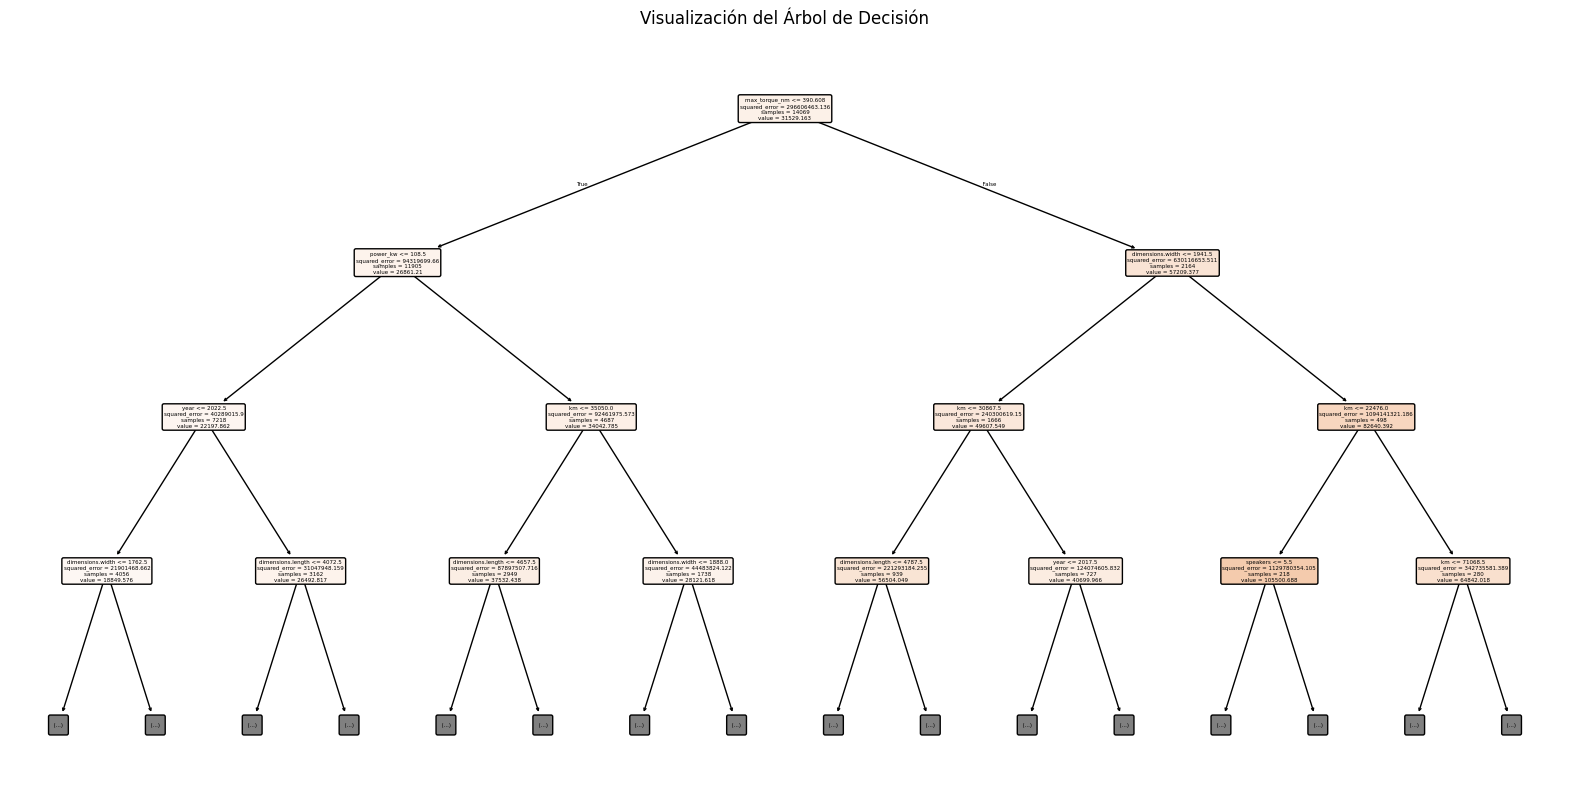

In [64]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Random Forest

In [65]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = RandomForestClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [66]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
idx,,,
158731,Luxury,Luxury,0
155241,Budget,Budget,0
80593,Budget,Budget,0
30019,Luxury,Luxury,0
158917,Premiun,Premiun,0


In [67]:
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7577114427860696 
 Precision: 0.7556755659477329 
 Recall: 0.7577114427860696 
 F1 Score: 0.7561846886773156
Confusion Matrix:
 [[1787    7    0    0   22   56  161    1    0]
 [   5  332    0    8   84    0   21   80    0]
 [   4    0   19    0    0   21    0    0    0]
 [   0    5    0  473    3    0    0   68    0]
 [  24   87    0    1  454    0  122   21    0]
 [  83    0   22    0    0  304    0    1    0]
 [ 225   28    1    0  123    1  718   14    0]
 [   1   66    0   70   17    1    5  481    0]
 [   0    0    1    0    0    1    0    0    1]]


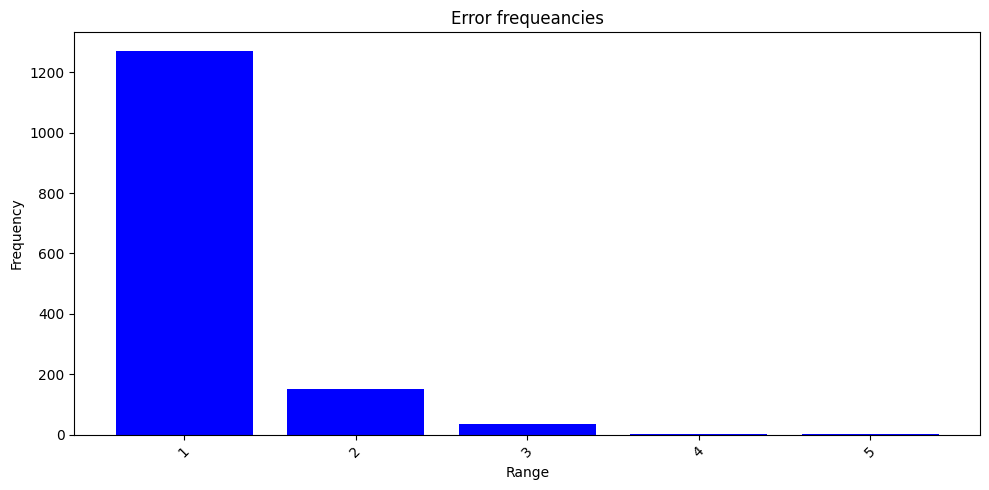

{np.int64(1): np.int64(1269), np.int64(2): np.int64(152), np.int64(3): np.int64(36), np.int64(4): np.int64(2), np.int64(5): np.int64(2)}
Error mean: 1.16290212183436
Error rate: 24.228855721393035 %
Overall mean: 0.28175787728026536


In [68]:
Evaluator.eval_ordinal_classification (result["diff"])

# Naive Bayes

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
import numpy as np
import pandas as pd

# Prepare the data
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Create the Naive Bayes model
nb_model = GaussianNB() # You can try other Naive Bayes models such as ComplementNB, BernoulliNB, BinomialNB but Gaussian gives the best results in this case

# Train the model
nb_model.fit(X_train, Y_train)

# Predict the labels of the test set
Y_pred = nb_model.predict(X_test)

# Create a results DataFrame to compare predictions
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)

# Show the first few rows of the results
result.head()


,Real_Categorie,Prediction,diff
idx,,,
158731,Luxury,Luxury,0
155241,Budget,Middle low range,1
80593,Budget,Premiun,4
30019,Luxury,Premiun,1
158917,Premiun,Premiun,0


In [70]:
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.42321724709784414 
 Precision: 0.487580242269124 
 Recall: 0.42321724709784414 
 F1 Score: 0.43538355868741296
Confusion Matrix:
 [[895  84  19  18 152  89 484 126 167]
 [ 18 208   1  63  67   0  11 162   0]
 [  3   0   1   0   0  31   1   0   8]
 [  2  31   1 435   4   0   0  76   0]
 [ 44 204   5  47 200   0  46 161   2]
 [ 84   0  12   2   4 290   4   0  14]
 [158 224   5  26 240   1 246 181  29]
 [  7  91   2 241  26   0   0 274   0]
 [  0   0   0   0   0   0   0   0   3]]


# Agorithms evaluation

In [71]:
hybird_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = hybird_cars[["price", "price_categ"]]
hybird_cars.drop(columns=["price", "price_categ"], inplace=True)


numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    hybird_cars[[column]] = scaler.fit_transform(hybird_cars[[column]])
    encoders_and_scalers[column] = scaler 

hybrid_cars_encoded = pd.get_dummies(hybird_cars, columns=categorical_column_names)

## Classification

In [72]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hybrid_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [73]:
from sklearn.model_selection import cross_val_score


def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    else:  Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)
    cv_scores = cross_val_score(classifier, X_test, y_test, cv=5, scoring='accuracy')
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")




### CART

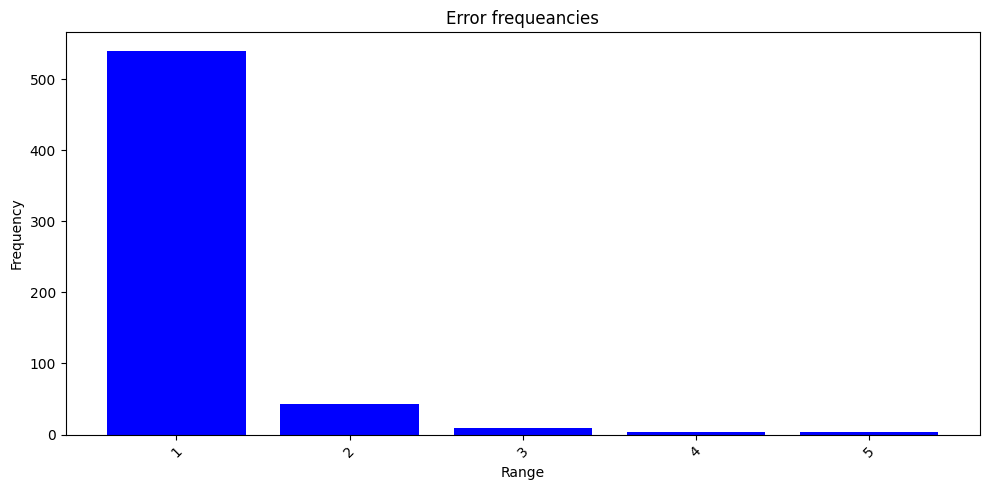

{np.int64(1): np.int64(539), np.int64(2): np.int64(43), np.int64(3): np.int64(9), np.int64(4): np.int64(3), np.int64(5): np.int64(3)}
Error mean: 1.137353433835846
Error rate: 9.900497512437811 %
Overall mean: 0.007296849087893864
Accuracy: 0.8059701492537313 
 Precision: 0.8058575333881521 
 Recall: 0.8059701492537313 
 F1 Score: 0.805795976153249
Confusion Matrix:
 [[ 331    0   19    0    0   55    0    0    1]
 [   2  354    0    5   92    1   17   71    0]
 [  14    0   27    1    0    4    0    0    1]
 [   0    7    0  479    0    0    0   52    0]
 [   1   97    0    1  486    5  128   10    0]
 [  37    3    0    0   12 1826  142    1    0]
 [   2   11    0    0   95  142  836    1    0]
 [   3   68    0   49   11    1    7  521    0]
 [   1    0    0    0    0    0    0    0    0]]


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


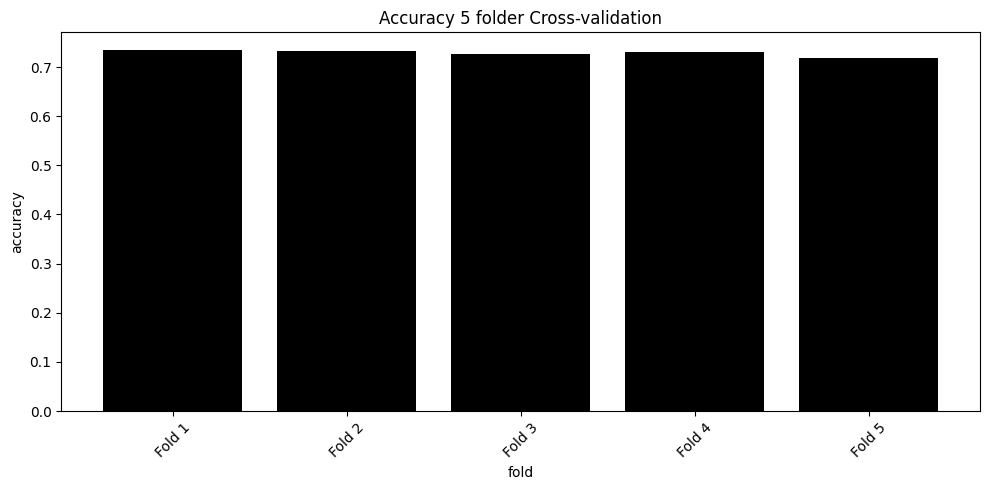

In [74]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest

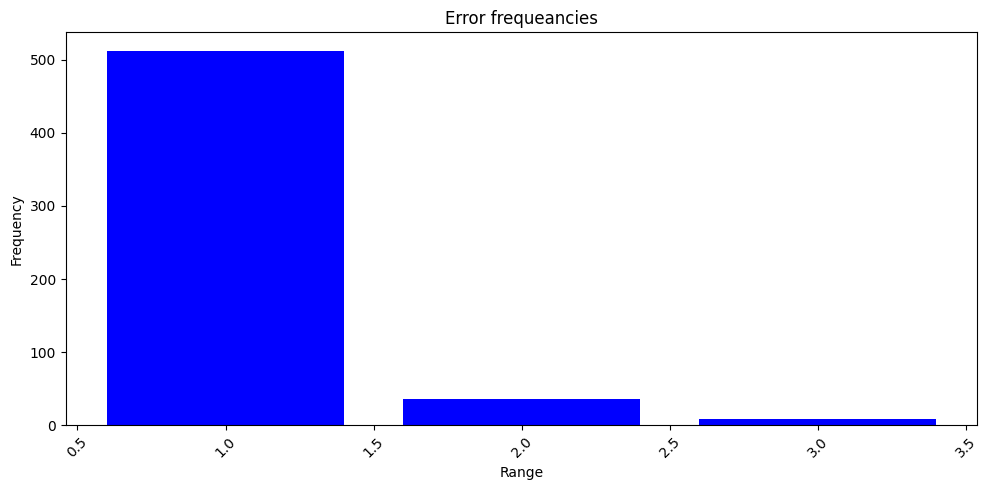

{np.int64(1): np.int64(512), np.int64(2): np.int64(36), np.int64(3): np.int64(9)}
Error mean: 1.0969479353680431
Error rate: 9.23714759535655 %
Overall mean: 0.00812603648424544
Accuracy: 0.8237147595356551 
 Precision: 0.8236667856426699 
 Recall: 0.8237147595356551 
 F1 Score: 0.8232872995248731
Confusion Matrix:
 [[ 332    0   12    0    0   62    0    0    0]
 [   0  374    0    2   86    2   12   66    0]
 [  18    0   24    1    0    2    1    0    1]
 [   0    1    0  459    0    0    0   78    0]
 [   0   79    0    0  509   11  117   12    0]
 [  32    0    0    0   13 1860  114    0    2]
 [   2    6    0    0   82  123  868    6    0]
 [   0   63    0   41   10    0    5  541    0]
 [   1    0    0    0    0    0    0    0    0]]


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


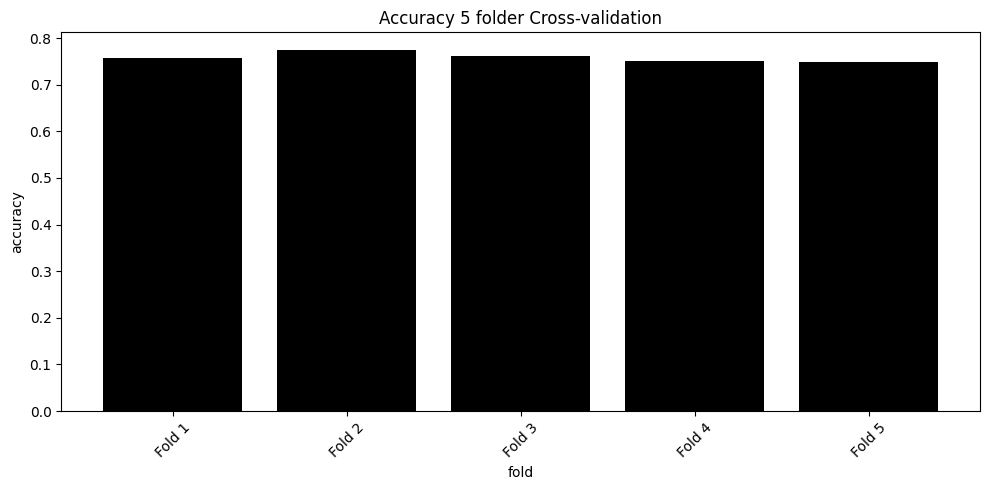

In [75]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM

In [ ]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

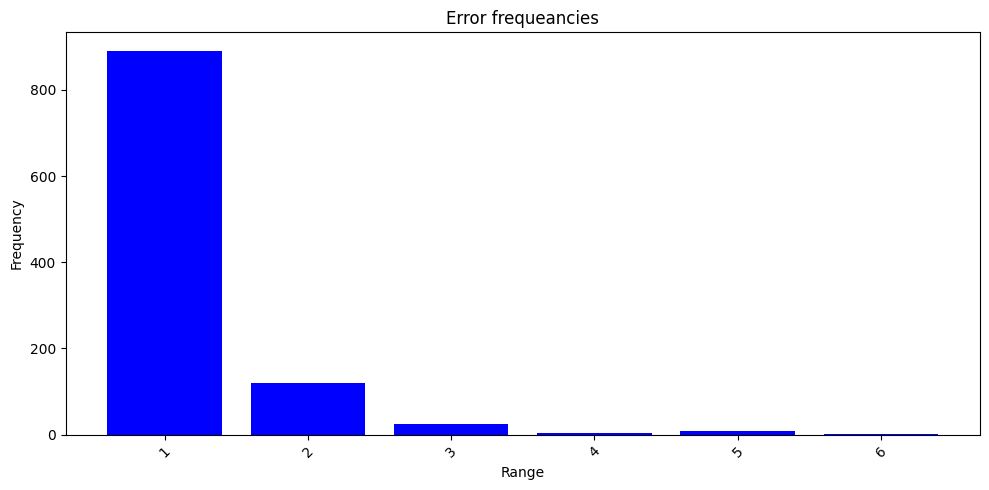

{np.int64(1): np.int64(889), np.int64(2): np.int64(119), np.int64(3): np.int64(25), np.int64(4): np.int64(3), np.int64(5): np.int64(8), np.int64(6): np.int64(2)}
Error mean: 1.2103250478011471
Error rate: 17.346600331674956 %
Overall mean: -0.27877280265339965
Accuracy: 0.46451077943615254 
 Precision: 0.6062028373133082 
 Recall: 0.46451077943615254 
 F1 Score: 0.46360305064436463
Confusion Matrix:
 [[211   0 174   0   2  15   3   0   1]
 [  2 451   0  35  23   2   6  23   0]
 [  6   1  37   0   0   1   1   0   1]
 [  2  18   0 495   1   0   0  22   0]
 [ 14 310   1  17 327   7  27  25   0]
 [362  35  38   3 374 677 527   4   1]
 [ 41 124   4   9 418  29 444  18   0]
 [  8 251   0 231   8   0   3 159   0]
 [  1   0   0   0   0   0   0   0   0]]


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


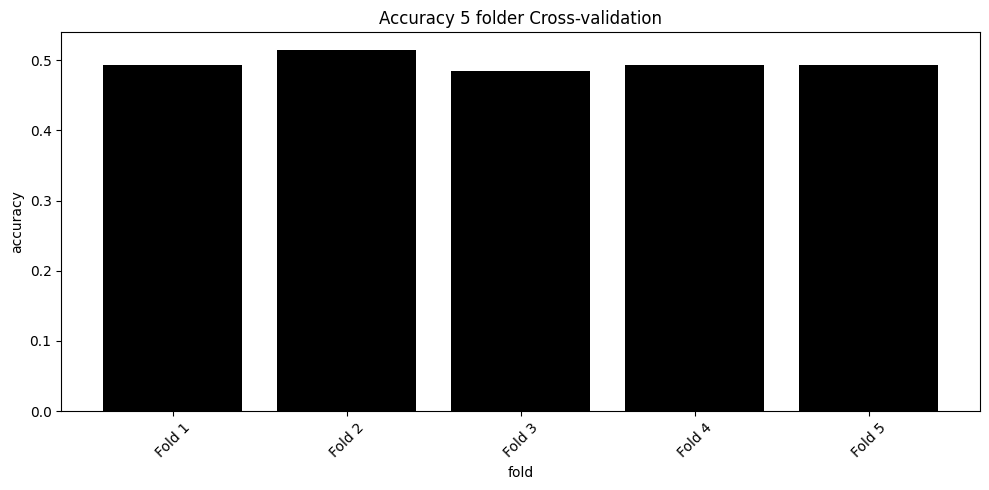

In [34]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [35]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    hybrid_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5173 - loss: 1.3579 - val_accuracy: 0.7370 - val_loss: 0.6988
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8192 - loss: 0.5102 - val_accuracy: 0.7580 - val_loss: 0.6436
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8599 - loss: 0.3731 - val_accuracy: 0.7642 - val_loss: 0.6375
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8824 - loss: 0.3104 - val_accuracy: 0.7665 - val_loss: 0.6400
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8854 - loss: 0.2804 - val_accuracy: 0.7783 - val_loss: 0.6427
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9020 - loss: 0.2474 - val_accuracy: 0.7788 - val_loss: 0.6471
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9138 - loss: 0.2160 - val_accuracy: 0.7857 - val_loss: 0.6586
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9182 - loss: 0.1973 - val_accu

In [36]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [37]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.7902155887230514 
 Precision: 0.7928459990462439 
 Recall: 0.7902155887230514 
 F1 Score: 0.7910859888112804
Confusion Matrix:
 [[ 329    0   24    0    0   53    0    0    0]
 [   1  340    0    2   97    3   21   78    0]
 [  15    0   28    0    0    2    1    0    1]
 [   0    5    0  443    2    0    0   88    0]
 [   1   70    0    4  497    9  130   17    0]
 [  49    2   11    0    8 1795  154    0    2]
 [   3    8    5    1  100  119  846    5    0]
 [   3   76    0   67   16    1   10  487    0]
 [   1    0    0    0    0    0    0    0    0]]


## Cart with Optuna

In [ ]:
classifier_target = target[["price_categ"]].values.ravel()

In [ ]:
ground_truth = classifier_target
classifiergen = ClassifierGenerator(hybrid_cars_encoded, classifier_target)
classifiergen.generate(n_trials=5)
classifiergen.save("hybrid")

## Regression

In [38]:
X_train, X_test, y_train, y_test = train_test_split(hybrid_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [41]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(hybrid_cars_encoded.columns), regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

### Cart

MAE: 1942.4620508568269 
 MSE: 15163432.075533181 
 RMSE: 3894.025176540745 
 R2: 0.949677376121919 
 MAPE: 5.963925085911304
Mean: 1942.4620508568269
Variance: 11390273.25651427
Standard Deviation: 3374.9478894516683
r2_adjusted: 0.8170113996616707


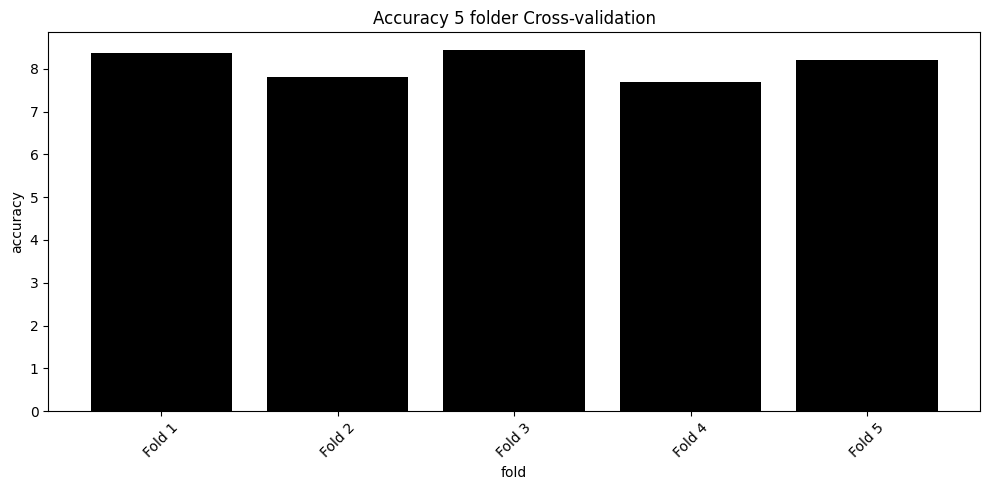

In [42]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### RandomForest

MAE: 1591.8629282163583 
 MSE: 8506249.978623098 
 RMSE: 2916.5476129532153 
 R2: 0.9717704530112367 
 MAPE: 4.964541852201107
Mean: 1591.8629282163583
Variance: 5972222.396393538
Standard Deviation: 2443.813085404352
r2_adjusted: 0.8973486497012942


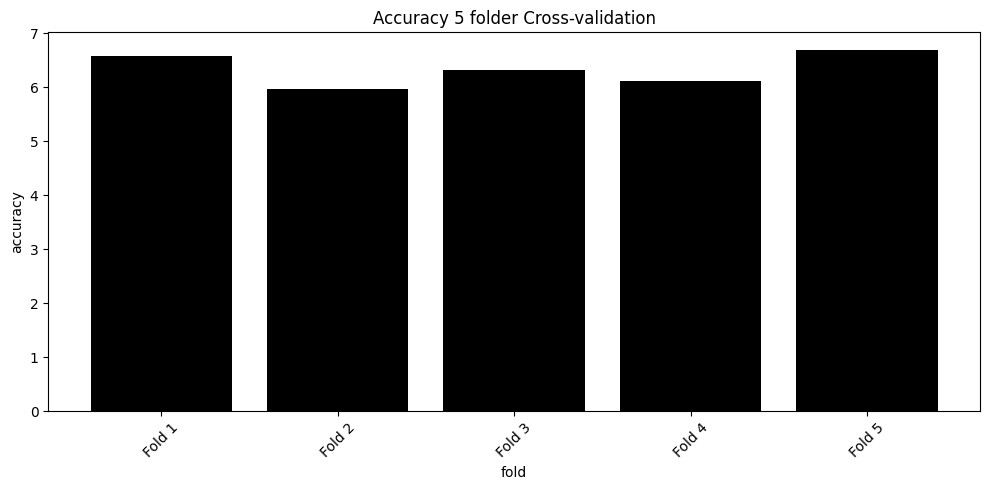

In [43]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

MAE: 10530.833249073552 
 MSE: 306042296.01755977 
 RMSE: 17494.06459395757 
 R2: -0.01565735755336628 
 MAPE: 33.08746249457059
Mean: 10530.833249073552
Variance: 195143847.0977667
Standard Deviation: 13969.38964657249
r2_adjusted: -2.6932437929368187


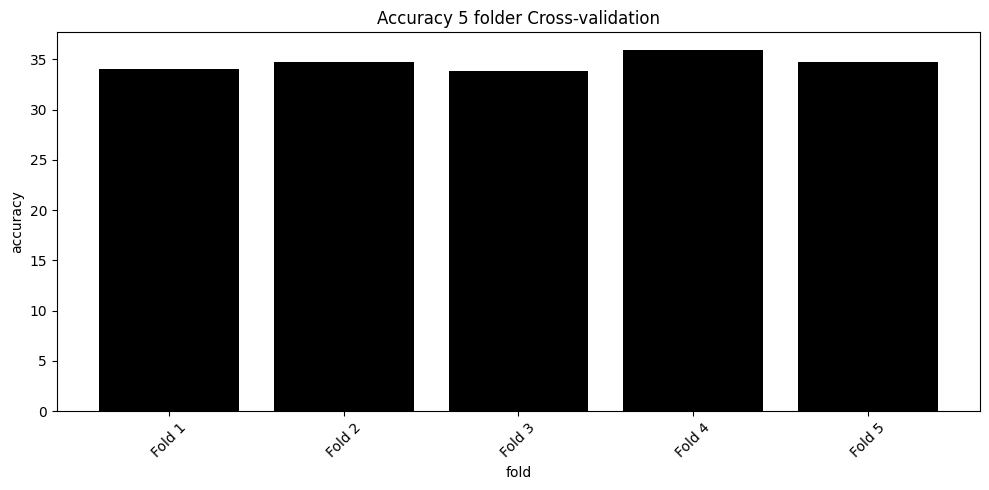

In [44]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

### Multivariable regression

In [45]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-4.79942103e+03  2.91823987e+03 -3.45132110e+10 ... -2.04070570e+14
  0.00000000e+00 -2.62363984e+13]
Intercept: -4189259924160746.0


In [46]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

MAE: 3801115389259.541 
 MSE: 3.3858626875887845e+26 
 RMSE: 18400713811123.7 
 R2: -1.1236604858426666e+18 
 MAPE: 14128027435.713682
Mean: 3801115389259.541
Variance: 3.2413779055641276e+26
Standard Deviation: 18003827108601.457
r2_adjusted: -4.08597651938808e+18


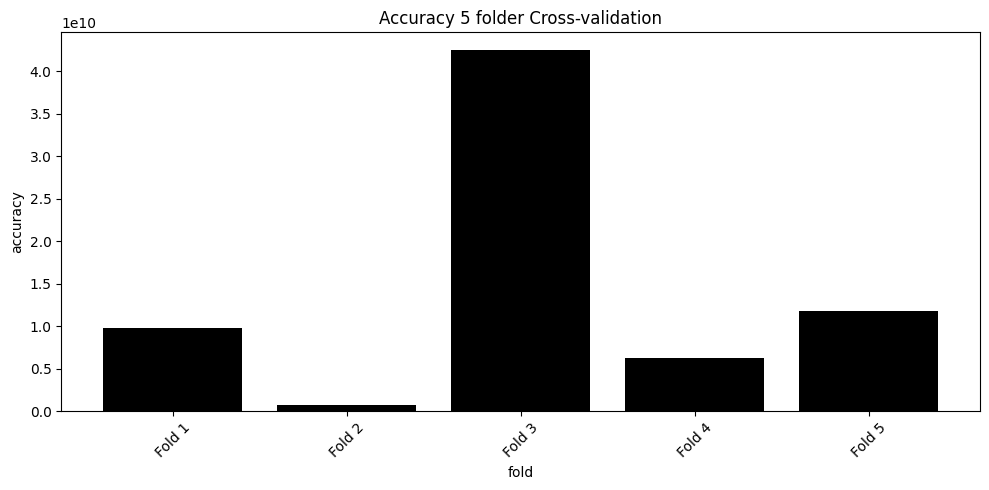

In [48]:
Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(hybrid_cars_encoded.columns), regressor_name="Lineal Regression")
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
cv_scores = -cross_val_score(linear_regressor, X_test, y_test, cv=5, scoring=mape_scorer)
Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

In [49]:
result

,Real,Prediction,diff
idx,,,
151243,47900,44194.0,3706.0
27724,26000,25164.0,836.0
95582,43549,42541.0,1008.0
22666,16490,16887.5,-397.5
73600,22500,22342.5,157.5
...,...,...,...
102354,46900,46278.5,621.5
132055,34900,35656.5,-756.5
102253,29850,24610.5,5239.5


 ### ANN Regression

In [50]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [52]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1278377344.0000 - mae: 31287.8984 - val_loss: 818945600.0000 - val_mae: 24183.6895
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 356184640.0000 - mae: 13604.6045 - val_loss: 72972720.0000 - val_mae: 5087.1270
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 61430108.0000 - mae: 4754.5620 - val_loss: 52605356.0000 - val_mae: 4137.0815
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46422328.0000 - mae: 3946.1914 - val_loss: 43581104.0000 - val_mae: 3640.7439
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37753632.0000 - mae: 3485.8171 - val_loss: 36810476.0000 - val_mae: 3357.9910
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 33346404.0000 - mae: 3150.5454 - val_loss: 31795098.0000 - val_mae: 3056.2773
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 24666324.0000 - mae: 2759.7361 - val_loss: 27656656.0000 - val_mae: 2861.9392
Epoch 8/100
110/110 

In [53]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

189/189 - 0s - 1ms/step - loss: 9393588.0000 - mae: 1795.5001
Mean Absolute Error on test set: 1795.50


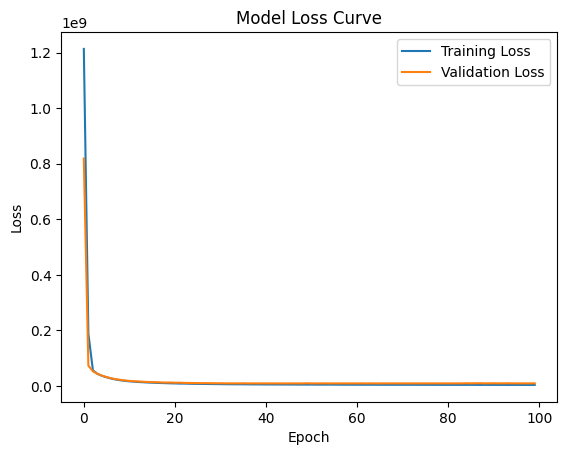

In [54]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [55]:
y_pred = model.predict(X_test).flatten()

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [56]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 1795.5003865762335 
 MSE: 9393586.053213743 
 RMSE: 3064.8957654729047 
 R2: 0.96882563829422 
 MAPE: 5.620546822479445
Mean: 1795.5003865762335
Variance: 6169764.415018339
Standard Deviation: 2483.9010477509646
r2_adjusted: 0.8866403940143861


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(48368.6, 0.0]",1442.887862,2.843161e+06,1686.167422,24742.382812,0.023438,5404
1,"(96737.2, 48368.6]",4448.466426,1.869380e+07,4323.632503,27297.179688,17.539062,563
2,"(145105.8, 96737.2]",8208.224008,6.753082e+07,8217.713907,48794.375000,335.695312,52
3,"(193474.4, 145105.8]",8215.912946,2.826933e+07,5316.891278,16642.078125,1238.296875,7


In [57]:
Evaluator.save("hybrid")

Regression results saved to: evaluation/hybrid_regression.tex
Classification results saved to: evaluation/hybrid_classification.tex
